# Deepwalk Implementation


In [95]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch import tensor, Tensor
from utils.deepwalk import DeepwalkModel, train_deepwalk
from torch.multiprocessing import cpu_count
from sklearn.manifold import TSNE

Các Hyperparameter


In [96]:
EMBEDDING_SIZE = 64
WALK_LENGTH = 10
WALKS_PER_VERTEX = 10
WINDOW_SIZE = 3
START_LEARNING_RATE = 0.025
END_LEARNING_RATE = 0.001
# Tiền xử lý 1D embedding
PREPROCESS_WALKS_PER_VERTEX = 10
# Dùng cho TSNE
PERPLEXITY = 20

device và worker_threads


In [97]:
WORKER_THREADS = torch.cuda.device_count() if torch.cuda.is_available() else cpu_count()
WORKER_THREADS = 1
CHUNK_SIZE = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
print(WORKER_THREADS)


cpu
1


Load dataset


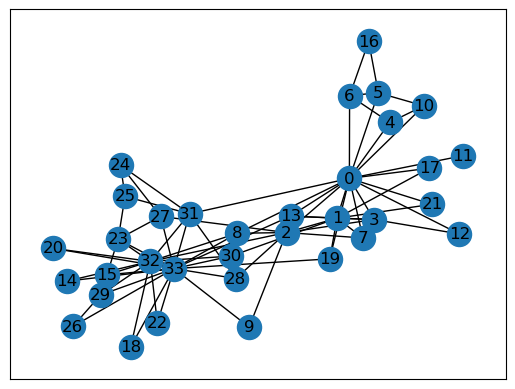

In [98]:
# Load dataset
# karate club
g: nx.Graph = nx.karate_club_graph()
adj_lists = [list(g.neighbors(v)) for v in g]
vertices = list(g)
V = len(g)
nx.draw_networkx(g)


### 1D Embedding

Embedding n-D bằng Deepwalk -> Embedding 1D bằng TSNE -> Sắp xếp lại thứ tự lá của Hierarchical Softmax


In [99]:
# ánh xạ từ đỉnh -> vị trí lá
leaf_pos = list(range(V))

# embedding sẽ được chuyển về 1 chiều bằng TSNE
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=(START_LEARNING_RATE + END_LEARNING_RATE) / 2.0,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=PREPROCESS_WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Text(0.5, 1.0, 'Hàm mất mát theo epoch')

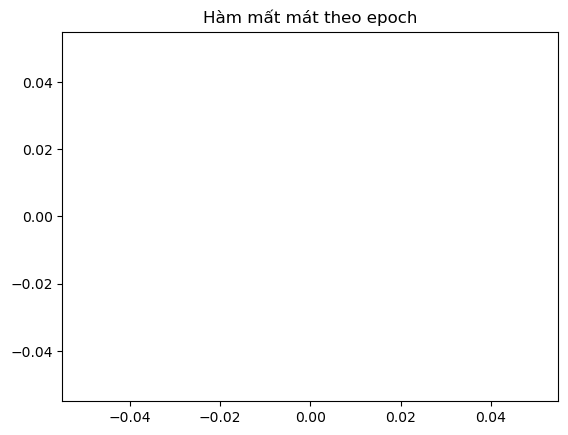

In [100]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

Chyển embedding về 1 chiều bằng TSNE rồi cập nhật lại vị trí lá cho Hierarchical Softmanx


In [101]:
# chuyển embedding về 1 chiều
emb: Tensor = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb = TSNE(n_components=1, perplexity=PERPLEXITY).fit_transform(emb).flatten()

# sắp xếp thứ tự các đỉnh
vertices.sort(key=lambda v: emb[v])

# cập nhật thứ tự lá cho các đỉnh
for pos, v in enumerate(vertices):
    leaf_pos[v] = pos

print(emb)
print(vertices)
print(leaf_pos)

ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### n-D Embedding


In [ ]:
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=END_LEARNING_RATE,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Text(0.5, 1.0, 'Hàm mất mát theo epoch')

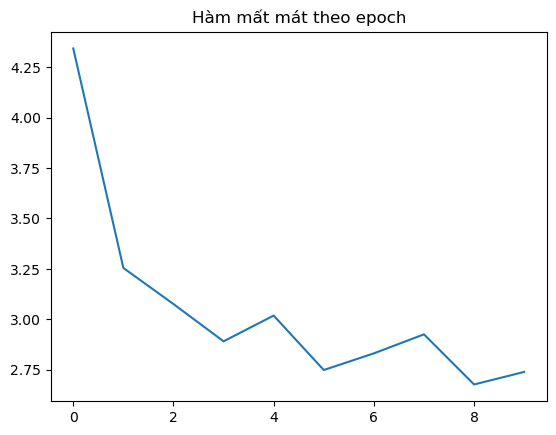

In [ ]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

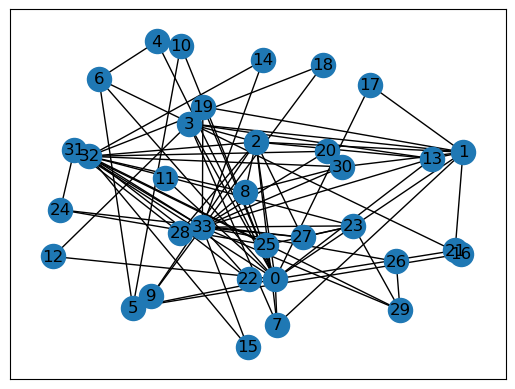

In [ ]:
emb = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb = TSNE(n_components=2, perplexity=PERPLEXITY).fit_transform(emb)
pos = {v: v_emb for v, v_emb in enumerate(emb)}

nx.draw_networkx(g, pos)
